In [3]:
import pandas as pd

df = pd.read_csv('../data/fraud.csv')
no_fraud_count = df[df['fraud_bool'] == 0]
fraud_count = df[df['fraud_bool'] == 1]

print(f"No fraud count: {no_fraud_count.shape[0]}")
print(f"Fraud count: {fraud_count.shape[0]}")
print(f"Ratio: {fraud_count.shape[0] / no_fraud_count.shape[0] * 100}%")

No fraud count: 988971
Fraud count: 11029
Ratio: 1.1151995356790039%


First to get insight about the data, we print first few rows, data types and summary statistics of the data.

In [106]:
print("First 5 rows of the data:")
print(df.head().to_string())

print("Columns of the data:")
print(df.columns.to_list())

print(df.describe().to_string())

First 5 rows of the data:
   fraud_bool  income  name_email_similarity  prev_address_months_count  current_address_months_count  customer_age  days_since_request  intended_balcon_amount  zip_count_4w   velocity_6h  velocity_24h  velocity_4w  bank_branch_count_8w  date_of_birth_distinct_emails_4w  credit_risk_score  email_is_free  phone_home_valid  phone_mobile_valid  bank_months_count  has_other_cards  proposed_credit_limit  foreign_request  session_length_in_minutes  keep_alive_session  device_distinct_emails_8w  device_fraud_count  month  payment_type_AA  payment_type_AB  payment_type_AC  payment_type_AD  payment_type_AE  employment_status_CA  employment_status_CB  employment_status_CC  employment_status_CD  employment_status_CE  employment_status_CF  employment_status_CG  source_INTERNET  source_TELEAPP  device_os_linux  device_os_macintosh  device_os_other  device_os_windows  device_os_x11  housing_status_BA  housing_status_BB  housing_status_BC  housing_status_BD  housing_status_B

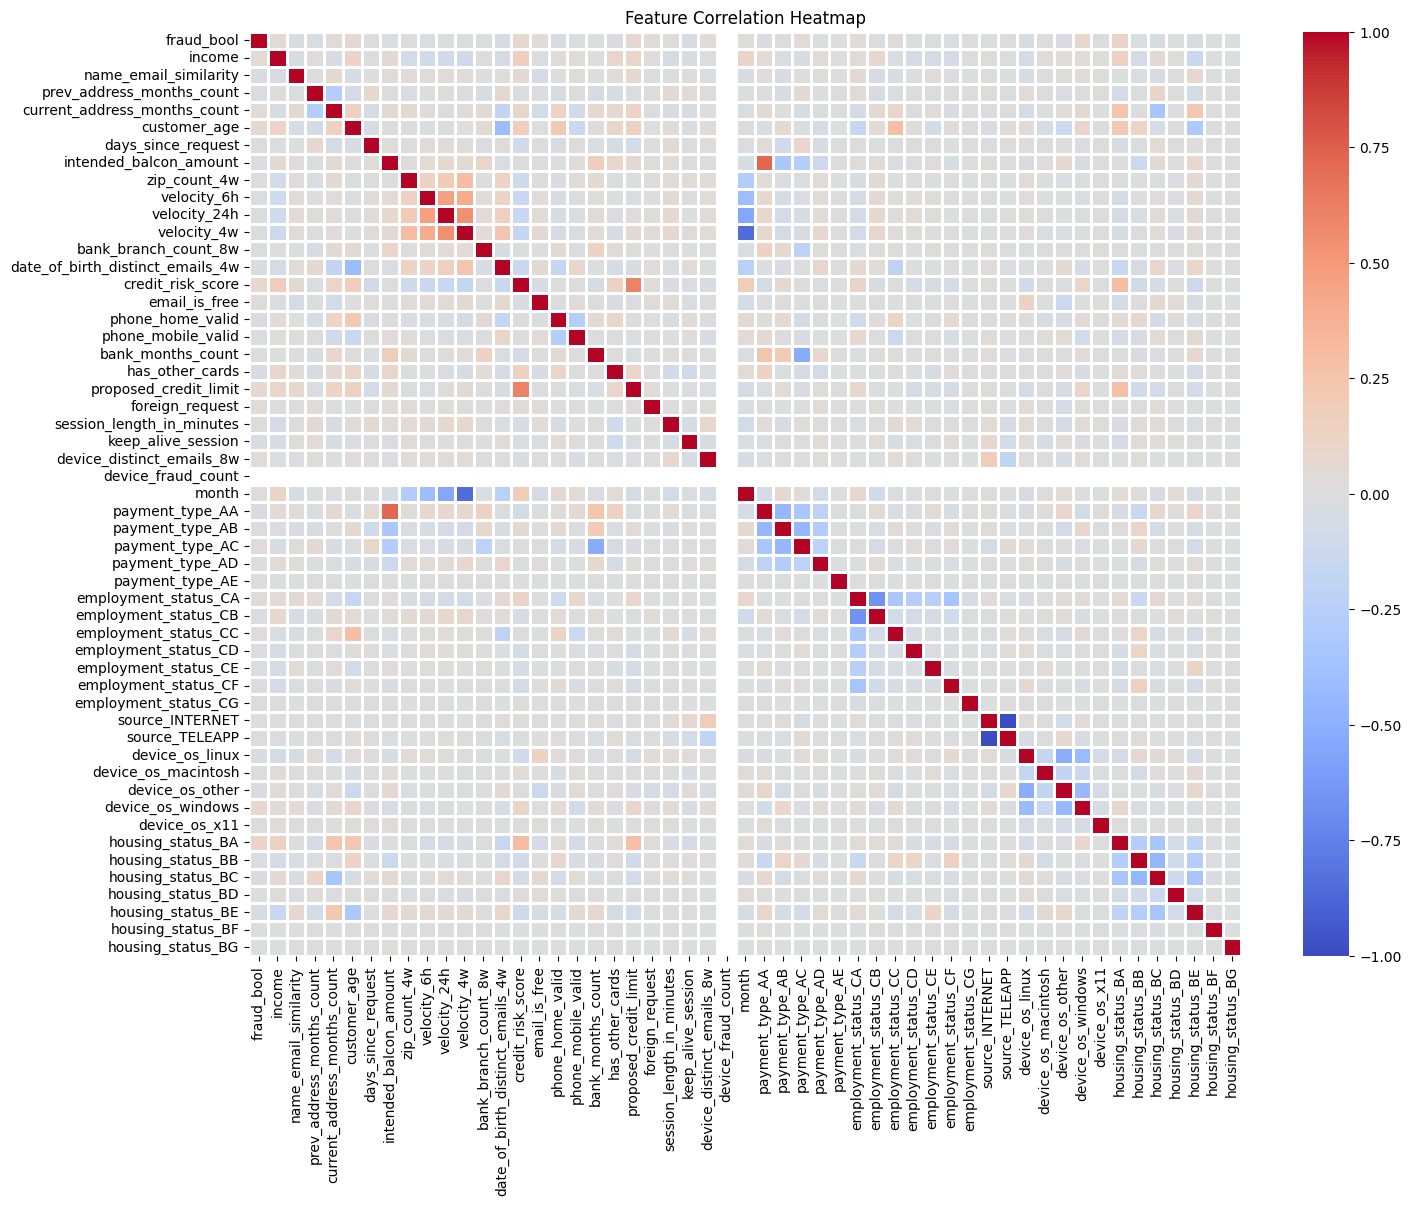

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/fraud.csv')

# Convert categorical variables into numeric (if necessary)
df = pd.get_dummies(df, columns=['payment_type', 'employment_status', 'source', 'device_os', 'housing_status'])

# Fill missing values if needed
# df = df.fillna(df.median())

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=1)
plt.title("Feature Correlation Heatmap")
plt.show()

housing_status_BA                   0.114428
device_os_windows                   0.078263
credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
income                              0.045079
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
payment_type_AC                     0.031510
email_is_free                       0.027758
employment_status_CC                0.025899
employment_status_CA                0.018231
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
device_os_macintosh                 0.006719
zip_count_4w                        0.005212
source_TELEAPP                      0.003922
payment_type_AB                     0.001629
employment_status_CG                0.000902
days_since_request                  0.000567
device_os_x11                       0.000145
payment_ty

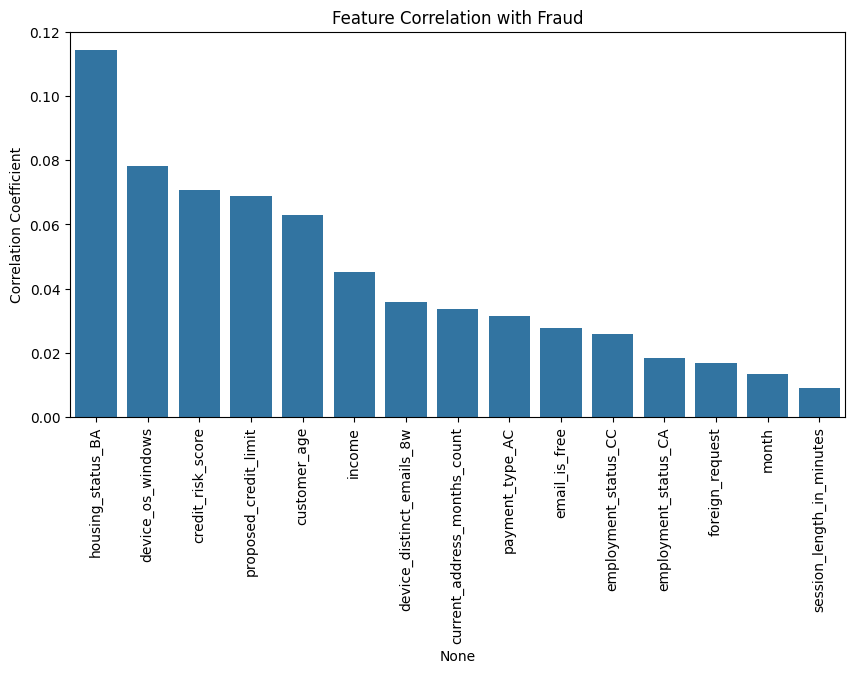

In [5]:
# Get correlation values sorted by importance
fraud_corr = corr_matrix["fraud_bool"].sort_values(ascending=False)

# Filter out fraud_bool column
fraud_corr = fraud_corr.drop("fraud_bool")
print(fraud_corr.to_string())

# Plot top 10 positive and negative correlations
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_corr.index[:15], y=fraud_corr.values[:15])
plt.xticks(rotation=90)
plt.title("Feature Correlation with Fraud")
plt.ylabel("Correlation Coefficient")
plt.show()

### KDE Plot (Best for Trends in Continuous Features)

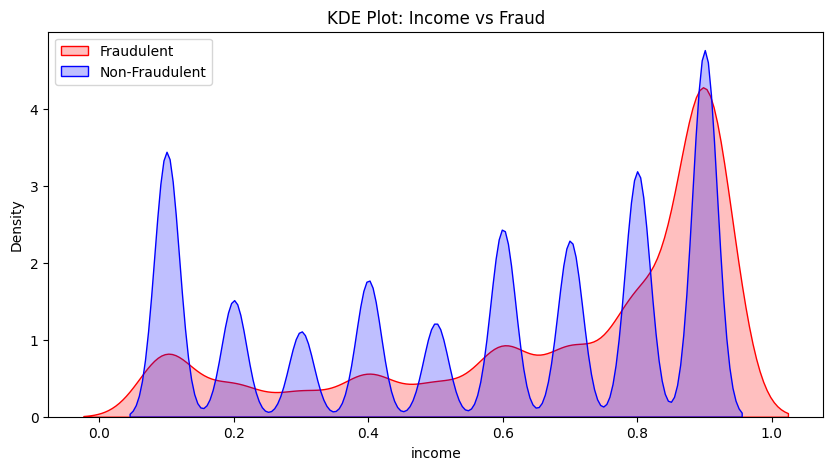

In [44]:
FEATURE_TO_INSPECT = "income"

plt.figure(figsize=(10, 5))
sns.kdeplot(df[df["fraud_bool"] == 1][FEATURE_TO_INSPECT], label="Fraudulent", fill=True, color="red")
sns.kdeplot(df[df["fraud_bool"] == 0][FEATURE_TO_INSPECT], label="Non-Fraudulent", fill=True, color="blue")
plt.title("KDE Plot: Income vs Fraud")
plt.legend()
plt.show()



### Boxplot (Good for Outliers & Trends)

<img src="../assets/boxplot.png" width="500"/>

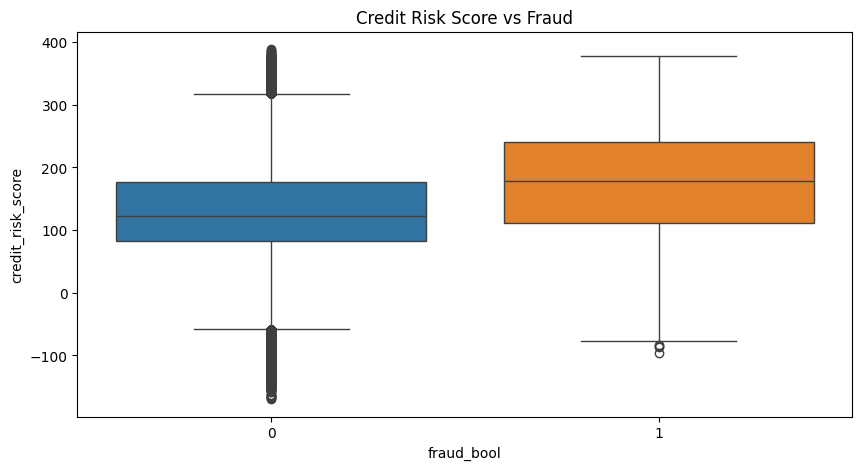

In [ ]:
FEATURE_TO_INSPECT = "credit_risk_score"

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="fraud_bool", y=FEATURE_TO_INSPECT, hue="fraud_bool", legend=False)
plt.title("Credit Risk Score vs Fraud")
plt.show()


### Bar Plot (Good for Categorical Features)

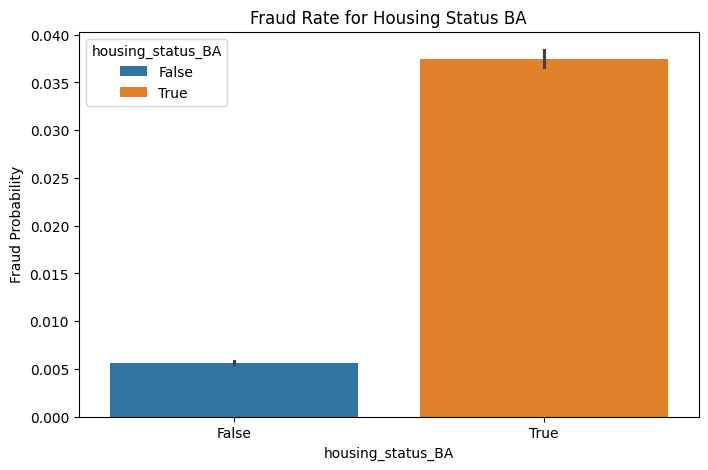

In [66]:
FEATURE_TO_INSPECT = "housing_status_BA"

plt.figure(figsize=(8, 5))
sns.barplot(x=FEATURE_TO_INSPECT, y="fraud_bool", data=df, hue=FEATURE_TO_INSPECT)
plt.title("Fraud Rate for Housing Status BA")
plt.ylabel("Fraud Probability")
plt.show()

### Count Plot (Good for Categorical Features)

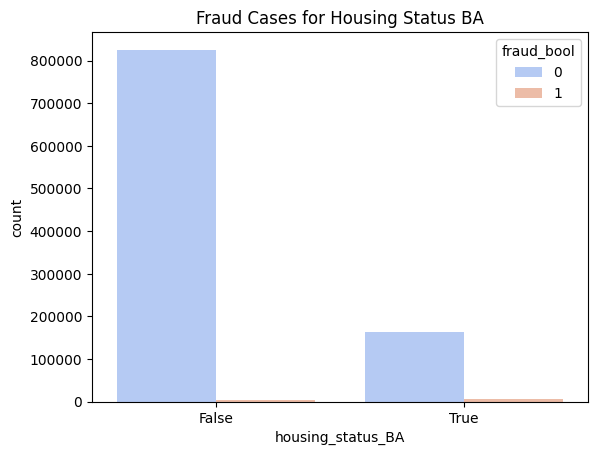

In [ ]:
sns.countplot(x="housing_status_BA", hue="fraud_bool", data=df, palette="coolwarm")
plt.title("Fraud Cases for Housing Status BA")
plt.show()

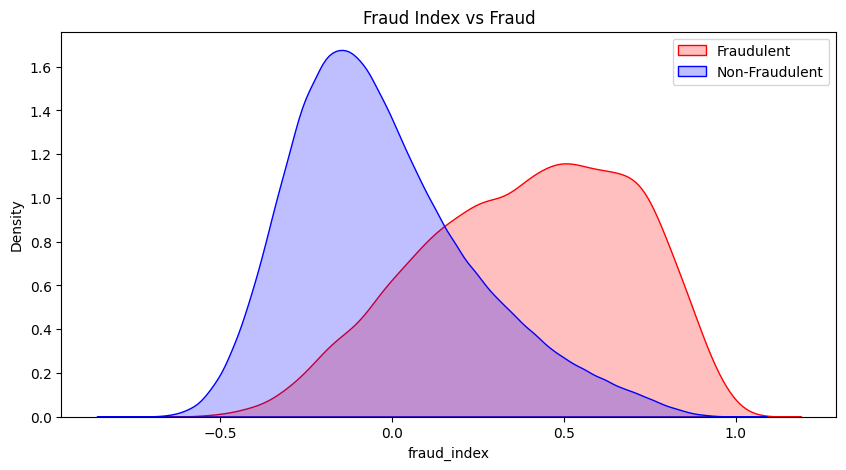

In [ ]:
import numpy as np

def calculate_fraud_index(df, fraud_corr):
    """
    Calculate a fraud index based on correlation values.
    
    Steps:
    1. Normalize numerical features to be between -1 and 1.
    2. Clamp boolean features to -1 (False) and 1 (True).
    3. Multiply each column by its correlation with fraud_bool.
    4. Sum across columns to get a fraud index for each row.
    
    Parameters:
        df (pd.DataFrame): The original dataset.
        fraud_corr (pd.Series): Correlation values of features with fraud_bool.
    
    Returns:
        pd.Series: Fraud index values for each row.
    """
    
    # Step 0: Select only the columns that have a correlation with fraud_bool
    selected_features = fraud_corr.index.tolist()
    df_selected = df[selected_features].copy()
    
    # Step 1: Normalize numerical features
    for col in df_selected.columns:
        if df_selected[col].dtype == 'bool':  
            # Convert boolean columns: False -> -1, True -> 1
            df_selected[col] = df_selected[col].astype(int) * 2 - 1
        elif np.issubdtype(df_selected[col].dtype, np.number):
            # Scale numerical columns based on mean and standard deviation
            mean = df_selected[col].mean()
            std = df_selected[col].std()
            df_selected[col] = (df_selected[col] - mean) / std
            df_selected[col] = df_selected[col].clip(-1, 1)  # Clamp to [-1, 1]
    
    # Step 2: Multiply each column by its correlation weight
    fraud_weights = fraud_corr.values
    fraud_index = df_selected.mul(fraud_weights, axis=1).sum(axis=1)
    
    return fraud_index

df["fraud_index"] = calculate_fraud_index(df, fraud_corr)

# Plot fraud index distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(df["fraud_index"][df["fraud_bool"] == 1], label="Fraudulent", fill=True, color="red")
sns.kdeplot(df["fraud_index"][df["fraud_bool"] == 0], label="Non-Fraudulent", fill=True, color="blue")
plt.legend()
plt.title("Fraud Index vs Fraud")
plt.show()

### Invalid Values
* `current_address_months_count`: Months in currently registered address of the applicant. Ranges between [−1, 406] months (-1 is a missing value).

* `intended_balcon_amount`: Initial transferred amount for application. Ranges between [−1, 108].

* `prev_address_months_count`: Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).

* `bank_months_count`: How old is previous account (if held) in months. Ranges between [−1, 31] months (-1 is a missing value).

* `session_length_in_minutes`: Length of user session in banking website in minutes. Ranges between [−1, 107] minutes

* `device_distinct_emails_8w`: Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [0, 3].

In [ ]:
# List the columns where -1 indicates missing data
missing_cols = [
    'current_address_months_count', 
    'prev_address_months_count', 
    'bank_months_count', 
    'session_length_in_minutes',
    'device_distinct_emails_8w'
]

# Replace -1 with np.nan in these columns
df[missing_cols] = df[missing_cols].replace(-1, np.nan)

# Identify boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (0 or 1)
df[bool_cols] = df[bool_cols].astype(int)